# Imports

In [1]:
import sys
import pprint
import json
import numpy as np
import pandas as pd
from dateutil.parser import parse
from pymongo import MongoClient
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim.summarization.summarizer import summarize
from numpy.linalg import norm
#from scipy.sparse.csc_matrix import transpose

#import seaborn as sns
%matplotlib inline


print("python Version:", sys.version)

python Version: 3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)


# Db Config

In [3]:
client = MongoClient()
db = client.presidents
paragraphs = db.submissions
full_speeches = db.fullspeeches

In [4]:
# speeches.delete_many({})

In [5]:
# with open('/home/karlrudeen/presidentialspeeches9.json', encoding='utf-8') as data_file:    
#     data = json.load(data_file)
#     speeches.insert_many(data)

In [6]:
paragraphs.count()

21968

In [7]:
full_speeches.count()

960

It is worth looking at our speech data on the speech level, and the paragraph within speech model. Speeches tend to cover a wide range of subjects, so when it comes to topic modeling, it may make more sense to model on individual paragraphs within speeches.

In [8]:
par_list = []

for par in paragraphs.find():
    #pprint.pprint(speech)
    if len(par['text']) > 140:
        par['text'] = par['text'].replace('</p>',' ')
        par_list.append(par)
        

#     speech_text.append(speech['text'].replace('<p>', '').\
#                        replace('(Applause.)',' ').replace('(applause)','').replace('inaudible','').split('<br>'))

In [9]:
df_pars = pd.DataFrame(par_list)

In [10]:
fullspeech_list = []

for fullspeech in full_speeches.find():
    if len(fullspeech['text']) > 500:
        fullspeech['text'] = fullspeech['text'].replace('\n',' ')
        fullspeech_list.append(fullspeech)

In [11]:
df_full_speeches = pd.DataFrame(fullspeech_list)

In [13]:
def num_freqs(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return m/len(arr1)   

In [14]:
def num_freqs_tup(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [15]:
def series_to_list(ser):
    return list(ser.tolist())

# NMF

The idea here is to do a grid search on varying levels of maximum document frequency (max_df) and number of topics (n_comps). The lower max_df is, the fewer words are included in the data.

I want to find a combination of n_comps and max_df that gives each president his own signature topic. I need some way to quantify how well the algorithm has done in this regard, so I created a metric. I call the metric Favorite Topic Frequency (FTF). The formula for FTF is FTF = t/s, where t is the total count of speeches by that president that fall under that presidents most frequent topic, and s is the total number of speeches given by that topic.

In [17]:
max_dfs = [.05, .10, .15, .20, .25, .30]
n_comps = [5,10,20,30,40]
speech_stats =[]

for freq in max_dfs:
    for n_comp in n_comps:
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                        stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
        tfidf_vectorizer.fit(df_speeches['text'])

        counts = tfidf_vectorizer.transform(df_speeches['text'])
        id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
        model = NMF(n_components=n_comp, init='random', random_state=0)
        doc_topics = model.fit_transform(counts)

        doc_cluster = [list(r).index(max(r)) for r in doc_topics]
        df_speeches['NMF_topic_num'] = doc_cluster

        tups = df_speeches.groupby('president').agg({
            'NMF_topic_num': num_freqs_tup
            })['NMF_topic_num']
        metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
        
        speech_stats.append((n_comp, freq, metricthing))

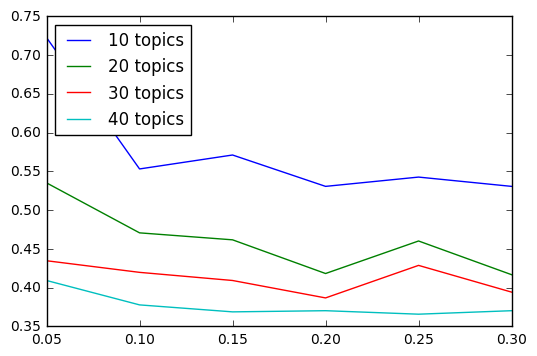

In [32]:
nums_tens = [(num[1],num[2]) for num in speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [25]:
fullspeech_list = []

for fullspeech in full_speeches.find():
    if len(fullspeech['text']) > 500:
        fullspeech['text'] = fullspeech['text'].replace('\n',' ')
        fullspeech_list.append(fullspeech)

In [26]:
df_full_speeches = pd.DataFrame(fullspeech_list)

In [25]:
max_dfs = [.05, .10, .15, .20, .25, .30]
n_comps = [10,20,30,40]
full_speech_stats = []

for freq in max_dfs:
    for n_comp in n_comps:
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                        stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
        tfidf_vectorizer.fit(df_full_speeches['text'])

        counts = tfidf_vectorizer.transform(df_full_speeches['text'])
        id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
        model = NMF(n_components=n_comp, init='random', random_state=0)
        doc_topics = model.fit_transform(counts)

        doc_cluster = [list(r).index(max(r)) for r in doc_topics]
        df_full_speeches['NMF_topic_num'] = doc_cluster

        tups = df_full_speeches.groupby('president').agg({
            'NMF_topic_num': num_freqs_tup
            })['NMF_topic_num']
        metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

        full_speech_stats.append((n_comp,freq,metricthing))

KeyboardInterrupt: 

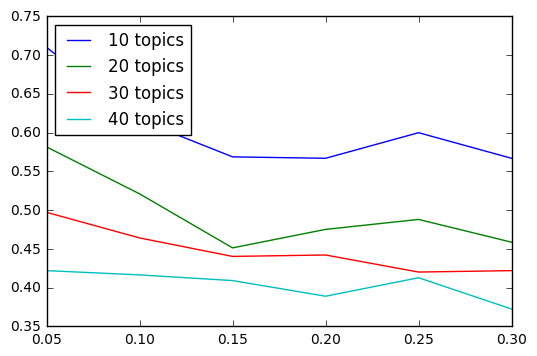

In [33]:
nums_tens = [(num[1],num[2]) for num in full_speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [29]:
full_speech_stats

[(10, 0.05, 0.710091743119266),
 (20, 0.05, 0.581651376146789),
 (30, 0.05, 0.4972477064220184),
 (40, 0.05, 0.42201834862385323),
 (10, 0.1, 0.6165137614678899),
 (20, 0.1, 0.5211009174311927),
 (30, 0.1, 0.46422018348623856),
 (40, 0.1, 0.41651376146788993),
 (10, 0.15, 0.5688073394495413),
 (20, 0.15, 0.45137614678899085),
 (30, 0.15, 0.44036697247706424),
 (40, 0.15, 0.4091743119266055),
 (10, 0.2, 0.5669724770642202),
 (20, 0.2, 0.47522935779816516),
 (30, 0.2, 0.44220183486238535),
 (40, 0.2, 0.3889908256880734),
 (10, 0.25, 0.6),
 (20, 0.25, 0.48807339449541287),
 (30, 0.25, 0.42018348623853213),
 (40, 0.25, 0.41284403669724773),
 (10, 0.3, 0.5669724770642202),
 (20, 0.3, 0.45871559633027525),
 (30, 0.3, 0.42201834862385323),
 (40, 0.3, 0.3724770642201835)]

In [ ]:
speech_stats

In [ ]:
full_speech_stats

In [18]:
def mode(arr):
    arr = [num for num in arr if num !=-1]
    m = max([arr.count(a) for a in arr])
    return [x for x in arr if arr.count(x) == m][0] if m>0 else None

In [19]:
def average_tuples(ser):
    mylist = ser.tolist()
    return [np.mean(tup) for tup in list(zip(*mylist))]

In [20]:
def my_count(arr, thing_to_count):
    return arr.count(thing_to_count)/len([num for num in arr if num !=-1])

In [ ]:
df_speeches

In [27]:
n_comp = 20
freq_full = .3


tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1, 2),  
                        stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq_full)
tfidf_vectorizer_full.fit(df_full_speeches['text'])


counts_full = tfidf_vectorizer_full.transform(df_full_speeches['text'])
counts_par = tfidf_vectorizer_full.transform(df_speeches['text'])

In [28]:
id2word_full = dict((v, k) for k, v in tfidf_vectorizer_full.vocabulary_.items())

model = NMF(n_components=n_comp, init='random', random_state=0)
model.fit(counts_full)
full_topics = model.transform(counts_full)

par_topics = model.transform(counts_par)
 

In [ ]:
full_cluster = [list(r).index(max(r)) if max(list(r)) > .005 else -1 for r in full_topics]
par_cluster = [list(r).index(max(r)) if max(list(r)) > .002 else -1 for r in par_topics]


In [ ]:
3 + 3

In [165]:
full_cluster.count(-1)

39

In [166]:
par_cluster.count(-1)/len(par_cluster)

0.1308950261247201

In [22]:
df_full_speeches['NMF_topic_num'] = full_cluster
df_full_speeches['NMF_topic_amts'] = [tuple(doc) for doc in full_topics]

In [23]:
df_speeches['NMF_topic_num'] = par_cluster
df_speeches['NMF_topic_amts'] = [tuple(doc) for doc in par_topics]


# okeything = df_full_speeches.groupby('president').agg({
#     'NMF_topic_num': num_freqs_tup,
#     'NMF_topic_amts' : average_tuples
#     })['NMF_topic_num']

tups = df_speeches.groupby('president').agg({
    'NMF_topic_num': num_freqs_tup
    })['NMF_topic_num']
metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

okeydoke = df_full_speeches.groupby('president', as_index = False).agg({
    'NMF_topic_num': series_to_list,
    'NMF_topic_amts' : average_tuples
    })

In [24]:
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([id2word_full[e[1]] for e in a])

In [27]:
df_speeches['date_obj'] = df_speeches['date'].apply(parse)

In [171]:
for i in range(n_comp):
    okeydoke['topic_' + str(i)] = okeydoke['NMF_topic_num'].apply(lambda x: my_count(x,i))
    #okeydoke['topic_amt_' + str(i)] = okeydoke['NMF_topic_amts'].apply(lambda x: x[i]/sum(x))

In [172]:
okeydoke['kmeans'] = KMeans(n_clusters = 7).fit_predict(okeydoke.iloc[:,3:23].as_matrix())

In [173]:
okeydoke['kmeans'].value_counts()

5    9
0    9
4    8
2    5
3    4
1    4
6    3
Name: kmeans, dtype: int64

In [175]:
okeydoke[okeydoke['kmeans']==0]

,president,NMF_topic_amts,NMF_topic_num,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,kmeans
1,Andrew Jackson,"[0.011036021672, 0.000994398470647, 0.00819941...","[18, -1, 4, 2, 4, 0, 2, 2, 4, 0, 15, 0, 0, 15]",0.307692,0.0,0.230769,0.0,0.230769,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.153846,0.0,0.000000,0.076923,0.000000,0
2,Andrew Johnson,"[0.00480153349097, 0.000344973132479, 0.019735...","[2, 11, 2, 2, 2, 6, 13, 6, 2, 2, 6, 2, 0, 2, 2...",0.103448,0.0,0.517241,0.0,0.000000,0.000000,0.103448,...,0.034483,0.000000,0.206897,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0
13,George Washington,"[0.00682797131999, 0.000153471065085, 0.001704...","[0, 0, -1, 13, 2, 0, 2, -1, -1, -1, -1]",0.500000,0.0,0.333333,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0
15,Grover Cleveland,"[0.00406777974385, 4.71819251023e-05, 0.003301...","[2, 5, 11, 9, 0, 9, 9, 11, 11, 11, 18, 5, 7, 1...",0.157895,0.0,0.157895,0.0,0.000000,0.157895,0.000000,...,0.210526,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.052632,0.052632,0
18,James Buchanan,"[0.00945690374841, 0.00124810483515, 0.0111984...","[12, 2, 0, 2, 0, 2, 0, 17, 2]",0.333333,0.0,0.444444,0.0,0.000000,0.000000,0.000000,...,0.000000,0.111111,0.000000,0.0,0.000000,0.0,0.111111,0.000000,0.000000,0
28,Martin Van Buren,"[0.00863167903633, 0.0, 0.00317475929547, 0.00...","[15, 0, 9, 2, 4]",0.200000,0.0,0.200000,0.0,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.200000,0.0,0.000000,0.000000,0.000000,0
32,Rutherford B. Hayes,"[0.00813260840649, 0.000417881310552, 0.018817...","[4, 17, 2, 2, 0, 2, 9, 2, 5, 11, 2, 9, 0]",0.153846,0.0,0.384615,0.0,0.076923,0.076923,0.000000,...,0.076923,0.000000,0.000000,0.0,0.000000,0.0,0.076923,0.000000,0.000000,0
35,Ulysses S. Grant,"[0.00643476195915, 0.000199560549467, 0.008226...","[2, 9, 6, 2, -1, 9, 11, 11, 0, 2, 9, 9, 2, 0, ...",0.181818,0.0,0.318182,0.0,0.000000,0.000000,0.045455,...,0.090909,0.000000,0.000000,0.0,0.090909,0.0,0.000000,0.000000,0.000000,0
39,William Taft,"[0.00905194199687, 0.0, 0.00608624839513, 0.0,...","[0, 0, 2, 2, 7]",0.400000,0.0,0.400000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0


In [30]:
import pickle

with open('par_data.pkl', 'wb') as picklefile:
    pickle.dump(speech_stats, picklefile)

In [31]:
with open('speech_data.pkl', 'wb') as picklefile:
    pickle.dump(full_speech_stats, picklefile)

In [189]:
import pickle
data = {'okeydoke' : okeydoke, 'topic_words': topic_words, 'df_speeches': df_speeches}
with open('dataprot.pkl', 'wb') as picklefile:
    pickle.dump(data, picklefile, protocol = 2)

In [14]:
with open("par_data.pkl", 'rb') as picklefile: 
    speech_stats = pickle.load(picklefile)

In [16]:
with open("speech_data.pkl", 'rb') as picklefile: 
    full_speech_stats = pickle.load(picklefile)

In [17]:
full_speech_stats

[(10, 0.05, 0.710091743119266),
 (20, 0.05, 0.581651376146789),
 (30, 0.05, 0.4972477064220184),
 (40, 0.05, 0.42201834862385323),
 (10, 0.1, 0.6165137614678899),
 (20, 0.1, 0.5211009174311927),
 (30, 0.1, 0.46422018348623856),
 (40, 0.1, 0.41651376146788993),
 (10, 0.15, 0.5688073394495413),
 (20, 0.15, 0.45137614678899085),
 (30, 0.15, 0.44036697247706424),
 (40, 0.15, 0.4091743119266055),
 (10, 0.2, 0.5669724770642202),
 (20, 0.2, 0.47522935779816516),
 (30, 0.2, 0.44220183486238535),
 (40, 0.2, 0.3889908256880734),
 (10, 0.25, 0.6),
 (20, 0.25, 0.48807339449541287),
 (30, 0.25, 0.42018348623853213),
 (40, 0.25, 0.41284403669724773),
 (10, 0.3, 0.5669724770642202),
 (20, 0.3, 0.45871559633027525),
 (30, 0.3, 0.42201834862385323),
 (40, 0.3, 0.3724770642201835)]

In [15]:
speech_stats 

[(5, 0.05, 0.8140929535232384),
 (10, 0.05, 0.7226386806596702),
 (20, 0.05, 0.5352323838080959),
 (30, 0.05, 0.43478260869565216),
 (40, 0.05, 0.40929535232383807),
 (5, 0.1, 0.7721139430284858),
 (10, 0.1, 0.553223388305847),
 (20, 0.1, 0.4707646176911544),
 (30, 0.1, 0.4197901049475262),
 (40, 0.1, 0.3778110944527736),
 (5, 0.15, 0.6476761619190404),
 (10, 0.15, 0.5712143928035982),
 (20, 0.15, 0.4617691154422789),
 (30, 0.15, 0.40929535232383807),
 (40, 0.15, 0.36881559220389803),
 (5, 0.2, 0.6596701649175413),
 (10, 0.2, 0.5307346326836582),
 (20, 0.2, 0.41829085457271364),
 (30, 0.2, 0.3868065967016492),
 (40, 0.2, 0.37031484257871067),
 (5, 0.25, 0.7181409295352323),
 (10, 0.25, 0.5427286356821589),
 (20, 0.25, 0.46026986506746626),
 (30, 0.25, 0.4287856071964018),
 (40, 0.25, 0.3658170914542729),
 (5, 0.3, 0.638680659670165),
 (10, 0.3, 0.5307346326836582),
 (20, 0.3, 0.41679160419790107),
 (30, 0.3, 0.39430284857571213),
 (40, 0.3, 0.37031484257871067)]

In [186]:
v = [1,2] + [3,4]

In [187]:
most_freq_topics[15]

IndexError: list index out of range

In [181]:
given_president = 'George W. Bush'
pres_row = okeydoke[okeydoke['president'] == given_president].iloc[0]
kmeans_cluster_num = int(pres_row['kmeans'])

closest_presidents = okeydoke[(okeydoke['kmeans'] == kmeans_cluster_num) & (okeydoke['president'] != given_president)]
if closest_presidents.shape[0] > 5:
    closest_presidents['distancesfromgiven'] = closest_presidents.apply(lambda row :norm(np.array(list(row)[3:23]) - np.array(list(pres_row)[3:23])), axis = 1)
    closest_presidents = closest_presidents.sort_values(by = 'distancesfromgiven', ascending = True).iloc[1:4,:]

most_freq_topics = list(pres_row['NMF_topic_num'])
most_freq_topic = mode(most_freq_topics)
print(topic_words[most_freq_topic])
print(list(closest_presidents['president']))
big_text_thing = ' '.join(list(df_speeches[(df_speeches['NMF_topic_num'] == most_freq_topic) & (df_speeches['president'] == given_president)]['text'])) #& (df_speeches['president'] == 'Barack Obama')]['text']))

['iraq', 'somalia', 'saddam', 'troops', 'kuwait', 'mission', 'kosovo']
['Bill Clinton', 'Barack Obama', 'Lyndon B. Johnson']


/home/karlrudeen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [184]:
summarize(big_text_thing, split = True)[:3]

['As the campaign unfolded, tens and thousands of our troops poured across the Iraqi border to liberate the Iraqi people and remove a regime that threatened free nations.',
 'The men and women who crossed into Iraq 5 years ago removed a tyrant, liberated a country, and rescued millions from unspeakable horrors.',
 'Some of those troops are with us today, and you need to know that the American people are proud of your accomplishment, and so is the Commander in Chief.']

In [66]:
most_freq_topics = list(pres_row['NMF_topic_num'])


In [67]:
most_freq_topics

[1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 11,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 11,
 11,
 -1,
 11,
 11,
 1,
 -1,
 -1,
 1,
 1,
 2,
 1,
 11,
 1,
 11,
 1,
 1,
 11,
 11,
 -1,
 11,
 11,
 11,
 11,
 11,
 -1,
 1,
 11,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 11,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 2,
 1,
 1,
 1,
 1,
 11,
 1,
 11,
 11,
 11,
 -1,
 -1,
 11,
 -1,
 -1,
 1,
 11,
 -1,
 -1,
 -1,
 -1,
 11,
 -1,
 -1,
 -1,
 1,
 11,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 11,
 1,
 -1,
 1,
 1,
 -1,
 13,
 11,
 11,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 11,
 11,
 11,
 11,
 11,
 -1,
 11,
 11,
 11,
 11,
 1,
 11,
 11,
 11,
 -1,
 11,
 11,
 11,
 -1,
 11,
 11,
 11,
 11,
 11,
 11,
 1,
 -1,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 -1,
 -1,
 -1,
 11,
 1,
 1,
 11,
 1,
 11,
 1,
 11,
 11,
 -1,
 -1,
 10,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 11,
 1,
 1,
 1,
 -1,

In [51]:
topic_words[2]

['states',
 'united states',
 'united',
 'said',
 'proclamation',
 'state',
 'persons']

In [ ]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

In [60]:
big_text_thing

'I don\'t know what kind of lives John McCain thinks that celebrities lead, but this has been mine. These are my heroes. Theirs are the stories that shaped me. And it is on their behalf that I intend to win this election and keep our promise alive as President of the United States. Now, last week, I had the honor of being sworn in for a second term as President of the United States.     And during my inaugural address, I talked about how making progress on the defining challenges of our time doesn’t require us to settle every debate or ignore every difference that we may have, but it does require us to find common ground and move forward in common purpose.  It requires us to act. Whereas the commissioners appointed by the President of the United   States to confer with the citizens in the western counties of Pennsylvania during   the late insurrection which prevailed therein, by their act and agreement bearing   date the 2d day of September last, in pursuance of the powers in them vest

'Whereas the commissioners appointed by the President of the United   States to confer with the citizens in the western counties of Pennsylvania during   the late insurrection which prevailed therein, by their act and agreement bearing   date the 2d day of September last, in pursuance of the powers in them vested,   did promise and engage that if assurances of submission to the laws of the United   States should be bona fide given by the citizens resident in the fourth survey   of Pennsylvania, in the manner and within the time in the said act and agreement   specified, a general pardon should be granted on the 10th day of July then next   ensuing of all treasons and other indictable offenses against the United States   committed within the said survey before the 22d day of August last, excluding   therefrom, nevertheless, every person who should refuse or neglect to subscribe   such assurance and engagement in manner aforesaid, or who should after such   subscription violate the same,

In [ ]:
LANGUAGE = "english"
SENTENCES_COUNT = 10
parser = PlaintextParser.from_string(big_text_thing, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

In [ ]:
Summar = Summarizer(big_text_thing)

In [ ]:
thing= summarize(big_text_thing, split = True)

In [ ]:
thing[1]

In [ ]:
topic_words[1]

In [ ]:
okeydoke[okeydoke['kmeans'] == 0]

# metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

In [ ]:
df_full_speeches[df_full_speeches['NMF_topic_num'] == 2]

In [ ]:
okeydoke

In [ ]:
okeydoke[okeydoke['KMeans'] == 2]

In [ ]:
np.bincount(sum(most_freq_topics,[]))

In [ ]:
mode(sum(most_freq_topics,[]))

In [ ]:
same_cluster_presidents
X = np.array(same_cluster_presidents.ix[4,2:22])
list(pres_row)

In [ ]:
pres_row = okeydoke[okeydoke['president'] == given_president]


In [ ]:
list(pres_row.iloc[0])

In [ ]:
same_cluster_presidents.ix[:,2:22]

In [ ]:
find_three_closest(same_cluster_presidents)

In [ ]:
norm([1,1])

In [190]:

nums = [(10, 0.05, 0.723404255319149),
 (20, 0.05, 0.598404255319149),
 (30, 0.05, 0.5159574468085106),
 (40, 0.05, 0.4521276595744681),
 (10, 0.1, 0.6542553191489362),
 (20, 0.1, 0.5851063829787234),
 (30, 0.1, 0.5132978723404256),
 (40, 0.1, 0.4601063829787234),
 (10, 0.15, 0.6675531914893617),
 (20, 0.15, 0.5053191489361702),
 (30, 0.15, 0.47074468085106386),
 (40, 0.15, 0.42819148936170215),
 (10, 0.2, 0.6117021276595744),
 (20, 0.2, 0.5531914893617021),
 (30, 0.2, 0.4627659574468085),
 (40, 0.2, 0.40425531914893614),
 (10, 0.25, 0.6223404255319149),
 (20, 0.25, 0.5425531914893617),
 (30, 0.25, 0.48404255319148937),
 (40, 0.25, 0.4228723404255319),
 (10, 0.3, 0.6595744680851063),
 (20, 0.3, 0.5159574468085106),
 (30, 0.3, 0.4601063829787234),
 (40, 0.3, 0.39361702127659576)]

In [ ]:
nums_tens = [(num[1],num[2]) for num in nums if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in nums if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in nums if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in nums if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')
